In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from dataloader import *
from _generator import *
from discriminator import *
from losses import * 
import utilities
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BASE_PRETRAIN_PATH = '/content/drive/MyDrive/trained_models/'
BASE_SAVE_PATH = '/content/drive/MyDrive/adjustParams/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initial Variables etc..


In [ ]:
# networks 

generator = Generator().to(device)
generator.load_model(BASE_SAVE_PATH + 'generator_checkpoint_e8_r2.pth')
generator = generator.train()

discriminator = Discriminator().to(device)
discriminator.load_model(BASE_SAVE_PATH + 'discriminator_checkpoint_e7.pth')
discriminator = discriminator.train()

VGG = getVGGConv4_4().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# losses 

content_loss = ContentLoss(VGG).to(device)
grayscale_loss = GrayscaleStyleLoss(VGG).to(device)
color_recon_loss = ColorReconLoss().to(device)
adversarial_loss = nn.MSELoss().to(device)


In [ ]:
# optimizers

# maybe come back and add weight decay 

pre_train_optim = optim.Adam(generator.parameters(), lr=0.0001)

gen_optim = optim.Adam(generator.parameters(), lr=0.00008)
dis_optim = optim.Adam(discriminator.parameters(), lr=0.00016)

In [ ]:
ANIME_PATH = '/content/drive/MyDrive/dataset/Shinkai/style/'
SMOOTH_PATH = '/content/drive/MyDrive/dataset/Shinkai/smooth/'
PHOTOS_PATH = '/content/drive/MyDrive/dataset/train_photo/'

photo_dataloader = getPhotoDataloader(PHOTOS_PATH)
anime_dataloader = getAnimeDataloader(ANIME_PATH, grayscale=True)
dis_dataloader = getPhotoAndAnimeDataloader(ANIME_PATH, SMOOTH_PATH, PHOTOS_PATH)

## Train the Network here:

In [ ]:
import pickle
from google.colab import files

EPOCHS = 10
START_EPOCH = 6
G_TO_D_RATIO = 5
LAMBDA_ADV = 100.
LAMBDA_CON = 0.01
LAMBDA_GRA = 10.
LAMBDA_COL = 5.
DISCRIMINATOR_FIRST = False
RANDOM_SKIP = 0.3 # roughly 1 to 4 ratio
# Math is: 
# discriminator 6,609 iterations / epoch = 26,438 photos / BATCH_SIZE(4)
# generator: 8,320 iterations / epoch = 6,656 images * G_TO_D_RATIO / BATCH_SIZE 
# discriminator * RANDOM_SKIP / generator is roughly 1 to 4


anime_iter = iter(anime_dataloader)

fake_true_labels = torch.ones((4,1,64,64)).to(device)
fake_fake_labels = torch.zeros((4,1,64,64)).to(device)

content_loss_list = utilities.readListFromPickle(BASE_SAVE_PATH + 'content_loss.pkl')
gray_loss_list = utilities.readListFromPickle(BASE_SAVE_PATH + 'gray_loss.pkl')
color_loss_list = utilities.readListFromPickle(BASE_SAVE_PATH + 'color_loss.pkl')
adv_loss_list = utilities.readListFromPickle(BASE_SAVE_PATH + 'adv_loss.pkl')
discriminator_loss_list = utilities.readListFromPickle(f'{BASE_SAVE_PATH}dis_loss.pkl')


for e in range(START_EPOCH, EPOCHS):  
  print("training generator")
  for r in range(G_TO_D_RATIO):
    if DISCRIMINATOR_FIRST:
      DISCRIMINATOR_FIRST = False
      break
    for p_batch_idx, photo_batch in enumerate(photo_dataloader):
      # train the generator
      
      gen_optim.zero_grad()
      
      anime_batch = next(anime_iter).to(device)
      if anime_batch.shape != photo_batch.shape:
        anime_iter = iter(anime_dataloader)
        continue

      # pass through generator network
      photo_batch = photo_batch.to(device)
      gen_images = generator(photo_batch)
      # gen_image is [4 x 3 x 256 x 256]

      # pass through discriminator network
      pred_labels = discriminator(gen_images)

      # calculate losses
      con_loss = content_loss(gen_images, photo_batch)
      gra_loss = grayscale_loss(gen_images, anime_batch)
      col_loss = color_recon_loss(gen_images, photo_batch)
      adv_loss = adversarial_loss(pred_labels, fake_true_labels)

      loss = LAMBDA_ADV * adv_loss + LAMBDA_CON * con_loss + \
              LAMBDA_GRA * gra_loss + LAMBDA_COL * col_loss
      
      # backpropogate
      loss.backward()
      gen_optim.step()

      # tell the discriminator to discriminate generated images
      if e < 5 and random.random() < 0.01:
        dis_optim.zero_grad()

        pred_labels = discriminator(gen_images)
        loss = 0.1 * adversarial_loss(pred_labels, labels)

        # backpropogate
        loss.backward()
        dis_optim.step()


      # save in list
      content_loss_list.append(con_loss.item())
      gray_loss_list.append(gra_loss.item())
      color_loss_list.append(col_loss.item())
      adv_loss_list.append(adv_loss.item())

      if p_batch_idx % 500 == 499:
        # save model at periodic checkpoints
        print("generator epoch:", e, "r:", r, "p_batch_idx", p_batch_idx, "loss:", loss.item())        
        utilities.saveListToPickle(BASE_SAVE_PATH + 'content_loss.pkl', content_loss_list)
        utilities.saveListToPickle(BASE_SAVE_PATH + 'gray_loss.pkl', gray_loss_list)
        utilities.saveListToPickle(BASE_SAVE_PATH + 'color_loss.pkl', color_loss_list)
        utilities.saveListToPickle(BASE_SAVE_PATH + 'adv_loss.pkl', adv_loss_list)
      
    print("saving sample generated images...")
    unique_identifier = f"e{e}r{r}idx"
    utilities.save_torch_as_images(BASE_SAVE_PATH, gen_images, unique_identifier=f'{unique_identifier}', is_standardized_image=True)
    utilities.save_torch_as_images(BASE_SAVE_PATH, gen_images, unique_identifier=f'_{unique_identifier}', is_standardized_image=True, adjust_brightness=True, imgs=photo_batch)
    print("done!")
    generator.save_model(f"{BASE_SAVE_PATH}generator_checkpoint_e{e}_r{r}.pth")

  generator.save_model(f"{BASE_SAVE_PATH}generator_checkpoint_e{e}.pth")
  
  print("training discriminator")
  for batch_idx, (photo_batch, labels) in enumerate(dis_dataloader):
    # trains the discriminator

    if random.random() < RANDOM_SKIP:
      # discriminator is trained too often, so randomly skip RANDOM_SKIP of images
      # to prevent discriminator from converging too quickly
      continue

    dis_optim.zero_grad()
    
    # send data to cuda if available    
    photo_batch = photo_batch.to(device)
    labels = labels.to(device)

    # pass through discriminator and get loss
    pred_labels = discriminator(photo_batch)
    loss = adversarial_loss(pred_labels, labels)

    # backpropogate
    loss.backward()
    dis_optim.step()
    
    discriminator_loss_list.append(loss.item())

    if batch_idx % 500 == 499:
      # save model at periodic checkpoints
      print("discriminator epoch:", e, "batch_idx", batch_idx, "loss:", loss.item())
      utilities.saveListToPickle(f'{BASE_SAVE_PATH}dis_loss.pkl', discriminator_loss_list)

  discriminator.save_model(f"{BASE_SAVE_PATH}discriminator_checkpoint_e{e}.pth")

generator.save_model(f"{BASE_SAVE_PATH}generator_final.pth")
discriminator.save_model(f"{BASE_SAVE_PATH}discriminator_final.pth")

# Some quick visual checks

In [ ]:
pred_labels = discriminator(gen_images)

In [ ]:
print(pred_labels)

In [ ]:
discriminator(photo_batch)

In [ ]:
print(labels)

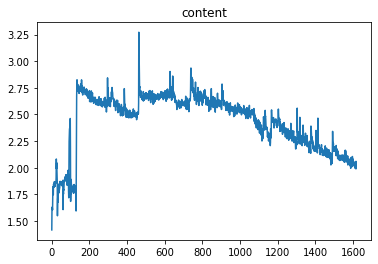

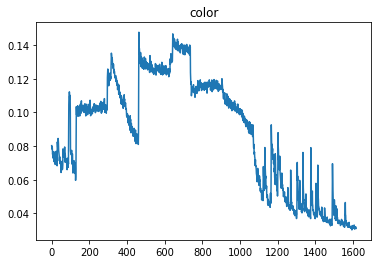

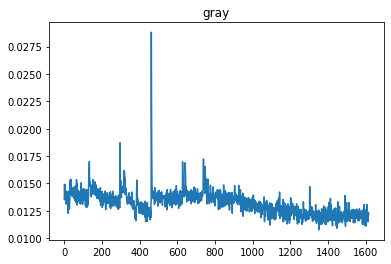

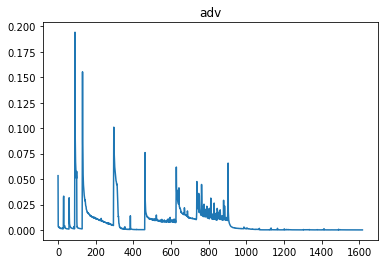

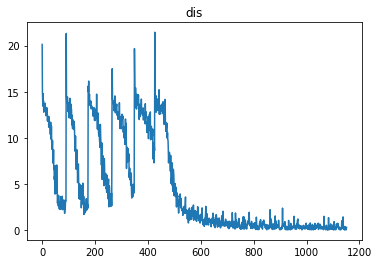

In [14]:
import matplotlib.pyplot as plt

# learning curves 

INTERVAL = 50

content_loss_list = utilities.listToAvg(utilities.readListFromPickle(BASE_SAVE_PATH + 'content_loss.pkl'), interval=INTERVAL)
color_loss_list = utilities.listToAvg(utilities.readListFromPickle(BASE_SAVE_PATH + 'color_loss.pkl'), interval=INTERVAL)
gray_loss_list = utilities.listToAvg(utilities.readListFromPickle(BASE_SAVE_PATH + 'gray_loss.pkl'), interval=INTERVAL)
adv_loss_list = utilities.listToAvg(utilities.readListFromPickle(BASE_SAVE_PATH + 'adv_loss.pkl'), interval=INTERVAL)
dis_loss_list = utilities.listToAvg(utilities.readListFromPickle(BASE_SAVE_PATH + 'dis_loss.pkl'), interval=INTERVAL)

f1 = plt.figure()
plt.title("content")
plt.plot(content_loss_list)

f2 = plt.figure()
plt.title("color")
plt.plot(color_loss_list)

f3 = plt.figure()
plt.title("gray")
plt.plot(gray_loss_list)

f4 = plt.figure()
plt.title("adv")
plt.plot(adv_loss_list)

f5 = plt.figure()
plt.title("dis")
plt.plot(dis_loss_list)